### Imports

In [1]:
import numpy as np
import pandas as pd
import imblearn
import random
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

### Clean data

In [2]:
data = pd.read_csv('./stroke_data.csv')
#find and fill null values with averages (BMI has 201 null values)
avg = data['bmi'].mean()
data.bmi=(data.bmi.fillna(avg))

#### Give numerical values to categorical variables

<table>
    <thead>
        <tr>
            <th colspan=2>work_type</th>
            <th colspan=2>gender</th>
            <th colspan=2>Residence_type</th>
            <th colspan=2>smoking_status</th>
            <th colspan=2>ever_married</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Private</td>
            <td>0</td>
            <td>Male</td>
            <td>0</td>
            <td>Urban</td>
            <td>0</td>
            <td>formerly smoked</td>
            <td>0</td>
            <td>Yes</td>
            <td>0</td>
        </tr>
        <tr>
            <td>Self-employed</td>
            <td>1</td>
            <td>Female</td>
            <td>1</td>
            <td>Rural</td>
            <td>1</td>
            <td>never smoked</td>
            <td>1</td>
            <td>No</td>
            <td>1</td>
        </tr>
        <tr>
            <td>Govt_job</td>
            <td>2</td>
            <td>smokes</td>
            <td>2</td>
        </tr>
        <tr>
            <td>children</td>
            <td>3</td>
            <td>Unknown</td>
            <td>3</td>
        </tr>
        <tr>
            <td>Never_worked</td>
            <td>4</td>
        </tr>
    </tbody>
</table>

In [3]:
data['work_type'] = data['work_type'].map({'Private':0, 'Self-employed': 1, 'Govt_job':2, 'children':3, 'Never_worked':4})
data['gender'] = data['gender'].map({'Male':0, 'Female':1})
data['Residence_type'] = data['Residence_type'].map({'Urban':0, 'Rural':1})
data['smoking_status'] = data['smoking_status'].map({'formerly smoked':0, 'never smoked':1, 'smokes':2, 'Unknown':3})
data['ever_married'] = data['ever_married'].map({'Yes':0, 'No':1})

#divide dataset into features and labels
#drop ID because it's not necessary for analysis
X = data.iloc[:, 1:-1]
y = data[['stroke']]

#replace null values again (1 in gender)
X.gender=(X.gender.fillna(1))

### Standardize data

In [4]:
def standardize(X):
    #Standardizes the data using the mean and standard deviation
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0, ddof=1)
    s_X = (X - mean)/std

    #add bias feature
    bias = (np.ones((s_X.shape[0], 1)))
    s_X = np.append(s_X, bias, axis=1)
    return s_X

In [5]:
s_X = standardize(X)

### Handle Imbalanced Data

In [6]:
smote = SMOTE()
s_X, y = smote.fit_resample(s_X, y)

### Functions used:

#### Sigmoid

In [7]:
def sigmoid(x, thetas):
    return (1/(1 + math.e ** -(x @ thetas)))

#### Gradient

In [8]:
def gradient(X_train, y_train, thetas): 
    sig = sigmoid(X_train, thetas)
    gradient = (X_train.T @ (sig - y_train))
    return gradient

#### Batch Gradient Descent

In [9]:
def logisticBGD(X_train, y_train, X_test, y_test, n, m, kfold):
    count_num = 0
    new_cost = 0
    percent_change = 1
    thetas = np.random.uniform(-1, 1, 11).reshape(11,1)
    
    #Terminate when absolute value change of loss on the data is
    #less than 2−23, or after 1500 iterations have passed (whichever occurs first).
    while (percent_change > (2 ** -23)):
        if (count_num == 1500):
            break

        #batch gradient descent
        thetas = thetas - ((n/m) * gradient(X_train, y_train, thetas))

        #cost
        total_cost = -np.sum((1/m) * ((y_train * np.log(sigmoid(X_train, thetas) + epsilon)) + (1 - y_train) * np.log(1 - sigmoid(X_train,thetas) + epsilon)))

        #percent change
        percent_change = abs((new_cost - total_cost)/total_cost)
        new_cost = total_cost

        count_num = count_num + 1

    #print("Thetas from batch gradient descent that minimize the loss function: ", thetas, "\n")
    if(kfold == "kfold"):
        accuracy, precision, recall, F1 = prediction(y_test, X_test, thetas, kfold)
        return accuracy, precision, recall, F1
    if(kfold == "no"):
        prediction(y_test, X_test, thetas, kfold)
        

#### Stochastic Gradient Descent

In [10]:
def logisticSGD(X_train, y_train, y_test, X_test, n, m, kfold):
    stoch_X_train = X_train
    stoch_y_train = y_train
    thetas = np.random.uniform(-1, 1, 11).reshape(11,1)
    new_cost = 1
    percent_change = 1
    count_num = 1
    
    #Terminate when absolute value change of loss on the data is less than 2−23, or after 1500 iterations have passed.
    while (percent_change > (2 ** -23)):
        if (count_num == 1500):
            break

        #stochastic gradient descent
        index = np.random.permutation(stoch_X_train.shape[0])
        stoch_X_train = np.take(stoch_X_train,index,axis=0)
        stoch_y_train = np.take(stoch_y_train,index,axis=0)
        thetas = thetas - ((n/m) * gradient(stoch_X_train, stoch_y_train, thetas))

        #cost
        total_cost = -np.sum((1/m) * (stoch_y_train * np.log(sigmoid(stoch_X_train, thetas) + epsilon)) + (1 - stoch_y_train) * np.log(1 - sigmoid(stoch_X_train,thetas) + epsilon))

        #percent change
        percent_change = abs((new_cost - total_cost)/total_cost)
        new_cost = total_cost
        count_num = count_num + 1

    #print("Thetas from stochastic gradient descent that minimize the loss function: ", thetas, "\n")
    if(kfold == "kfold"):
        accuracy, precision, recall, F1 = prediction(y_test, X_test, thetas, kfold)
        return accuracy, precision, recall, F1
    if(kfold == "no"):
        prediction(y_test, X_test, thetas, kfold)

#### K-Folds split the data

In [11]:
def cv_split(data, numfolds):
    dataset = data
    data_folds = []
    fold_size = int(dataset.shape[0] / numfolds)
        
    for i in range(numfolds):
        fold = []
        
        #add random data to the folds
        while len(fold) < fold_size: 
            index = random.randrange(dataset.shape[0])
            # save data at index to fold 
            fold.append(dataset.iloc[index].values.tolist())
            # delete data line from dataset
            dataset = dataset.drop(index,axis = 0)  
            dataset.reset_index(drop=True, inplace=True)
        data_folds.append(np.asarray(fold))
            
    return data_folds

#### Cross Validation K-Folds

In [12]:
def kfold(data, model, kfold, f=5):
    data=cv_split(data,f)
    result=[]
    accuracy = []
    precision = []
    recall = []
    F1 = []
    
    # determine training and test sets 
    for i in range(f):
        r = list(range(f))
        testi = data[i]
        r.pop(i)
        for j in r :
            if j == r[0]:
                traini = data[j]
            else: 
                traini=np.concatenate((traini,data[j]), axis=0)
        
        k_train_x = traini[:, 0:-1]
        k_train_y = traini[:, -1]
        k_train_y = k_train_y.reshape(k_train_y.shape[0],1)
        k_test_x = testi[:, 0:-1]
        k_test_y = pd.DataFrame(testi[:, -1])
        
        if(model == "batch"):
            accuracy1, precision1, recall1, F11 = logisticBGD(k_train_x, k_train_y, k_test_x, k_test_y, n, m, kfold)
            accuracy.append(accuracy1)
            precision.append(precision1)
            recall.append(recall1)
            F1.append(F11)
        if(model == "stochastic"):
            accuracy1, precision1, recall1, F11 = logisticSGD(k_train_x, k_train_y, k_test_y, k_test_x, n, m, kfold)
            accuracy.append(accuracy1)
            precision.append(precision1)
            recall.append(recall1)
            F1.append(F11)
    print("Accuracies: ", np.array(accuracy)*100)
    print("Precisions: ", np.array(precision)*100)
    print("Recalls: ", np.array(recall)*100)
    print("F-measures: ", np.array(F1)*100)

#### Predict

In [13]:
def prediction(y_test, X_test, thetas, kfold):
    size_test = y_test.shape[0]
    predictions = np.zeros(size_test)
    TP = FP = TN = FN = accuracy = 0

    #find probability for 1 and 0
    for a in range(size_test):
        p_1 = 1/(1 + math.e ** -(X_test[a] @ thetas))
        p_0 = 1 - p_1
        if(p_1 > p_0):
            predictions[a] = 1
        else:
            predictions[a] = 0

    #find TP, FP, TN, FN
    for a in range(size_test):
        if (predictions[a] == 1):
            if (predictions[a] == y_test.iloc[a][0]):
                TP = TP + 1
                accuracy = accuracy + 1
            else:
                FP = FP + 1 
        else:
            if(predictions[a] == y_test.iloc[a][0]):
                TN = TN + 1
                accuracy = accuracy + 1
            else:
                FN = FN + 1

    #precision, recall, f measure, accuracy
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = (2*precision*recall)/(precision + recall)
    accuracy = accuracy/size_test
    
    if(kfold == "kfold"):
        return accuracy, precision, recall, F1
    
    else:
        print("Accuracy: ", accuracy* 100)
        print("Precision: ", precision * 100)
        print("Recall: ", recall* 100)
        print("F-measure: ", F1* 100)
        print("TP: ", TP,"; FP: ", FP, "; TN: ", TN, "; FN: ", FN)

## Results Without K-Folds

#### Split the dataset into train and test

In [14]:
X_train,X_test, y_train,y_test=train_test_split(s_X,y,test_size=0.33,random_state=0)
y_train = y_train.values

#### Common Variables

In [15]:
random.seed(0)
n = 0.01 #learning rate
count = pd.DataFrame()
percent_change = 1
count_num = 1
cost = 1
m = X_train.shape[0]
#y_train = y_train.to_numpy()
epsilon = 1e-5 

#### Logistic Regression using Batch Gradient Descent

In [16]:
logisticBGD(X_train, y_train, X_test, y_test, n, m, "no")

Accuracy:  78.43564973511997
Precision:  75.70872707059478
Recall:  84.2300556586271
F-measure:  79.74238875878221
TP:  1362 ; FP:  437 ; TN:  1155 ; FN:  255


#### Logistic Regression using Stochastic Gradient Descent

In [17]:
logisticSGD(X_train, y_train, y_test, X_test, n, m, "no")

Accuracy:  78.37332502337176
Precision:  74.82517482517483
Recall:  86.0235003092146
F-measure:  80.03452243958573
TP:  1391 ; FP:  468 ; TN:  1124 ; FN:  226


#### Built-in function

Accuracy:  0.7834216266749766
Precision:  0.7640320733104238
Recall:  0.8249845392702535
F-measure:  0.7933392804044008


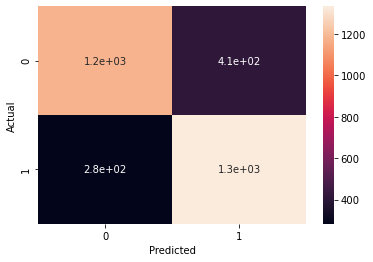

In [18]:
X_train,X_test, y_train,y_test=train_test_split(s_X,y,test_size=0.33,random_state=0)
y_train = y_train.values.ravel()
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn

#y_train = y_train.ravel()
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
y_test = y_test.values
y_test = y_test.reshape(3209,)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred,zero_division=0))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F-measure: ',metrics.f1_score(y_test, y_pred,zero_division=0))

plt.show()

## Results With K-Folds

In [19]:
data = np.append(s_X, y, axis=1)
data = pd.DataFrame(data)

#### Logistic Regression using Batch Gradient Descent, k-folds = 5

In [20]:
kfold(data, "batch", "kfold", 5)

Accuracies:  [77.52057613 79.218107   78.49794239 80.19547325 77.52057613]
Precisions:  [72.65556529 76.93693694 74.64920486 77.65363128 74.52574526]
Recalls:  [86.89727463 85.22954092 84.44444444 85.18896834 84.18367347]
F-measures:  [79.14081146 80.87121212 79.24528302 81.24695567 79.0608529 ]


#### Logistic Regression using Stochastic Gradient Descent, k-folds = 5

In [21]:
kfold(data, "stochastic", "kfold", 5)

Accuracies:  [77.41769547 78.24074074 79.16666667 78.7037037  77.98353909]
Precisions:  [72.88888889 74.50805009 76.17421008 74.375      73.42781222]
Recalls:  [85.95387841 85.78784758 87.62278978 86.77083333 86.62486938]
F-measures:  [78.88407888 79.75107707 81.4984011  80.09615385 79.4822627 ]
